### IMPORTING THE DATA

In [13]:
import pandas as pd
from pmdarima import auto_arima
data=pd.read_csv('Light_Rail_Patronage.csv',parse_dates=True)
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Date          631 non-null    object
 1   MyWay         631 non-null    int64 
 2   Paper Ticket  631 non-null    int64 
 3   Total         631 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 19.8+ KB


### SORTING THE DATES

In [14]:
x=[]
y=[]
z=[]
for i in data['Date'].str.split('/'):
        x.append(i[0])
        y.append(i[1])
        z.append(i[2])
d=pd.DataFrame([x,y,z])
d=d.T
s=[]
for i,j,k in zip(d[0],d[1],d[2]):
    s.append(pd.Timestamp(day=int(i),month=int(j),year=int(k)))
data['Date']=s
data=data.sort_values('Date')

### PLOTTING THE TOTAL PATRONAGE

Text(0, 0.5, 'NO OF PATRONAGE')

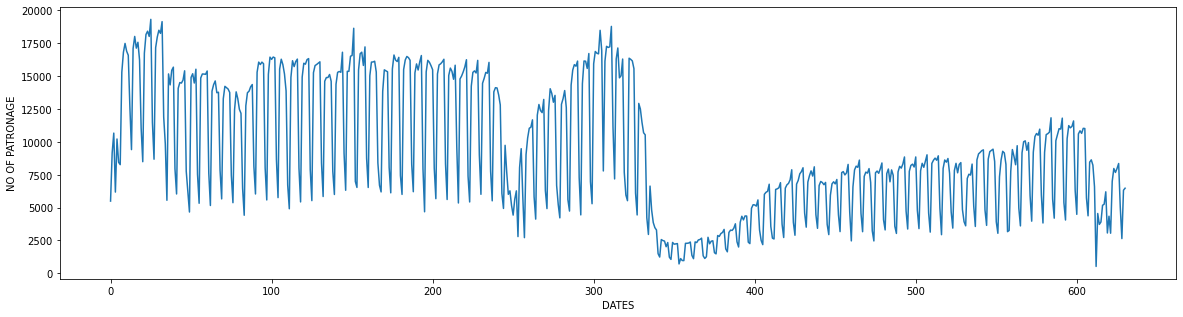

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,5))
plt.plot([i for i in range(0,631)],data['Total'])
plt.xlabel('DATES')
plt.ylabel('NO OF PATRONAGE')

###SPLITTING THE DATA INTO TRAIN AND TEST

In [16]:
train=data['Total'][0:-7]
test=data['Total'][-7:]

In [17]:
import warnings
warnings.filterwarnings('ignore')

### EXPONENTIAL SMOOTHING MODEL

In [18]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model=ExponentialSmoothing(train,trend='add',seasonal='mul',seasonal_periods=7).fit()
exponential_predictions=model.forecast(7)

### SOME PREPROCESS FOR ARIMA

### CHECKING THE SEASONALITY AND TREND USING ETS DECOMPOSE[ERROR TREND SEASONALITY]

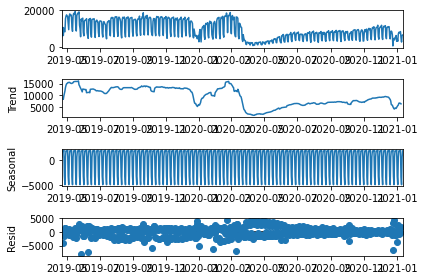

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
data=data[['Total','Date']]
data=data.set_index('Date')
data.index=pd.to_datetime(data.index)
data=data.asfreq('d')
data=data.fillna(method='bfill')
seasonal=seasonal_decompose(data,model='additive')
seasonal.plot();

###PLOTTING ACF AND PACF PLOTS

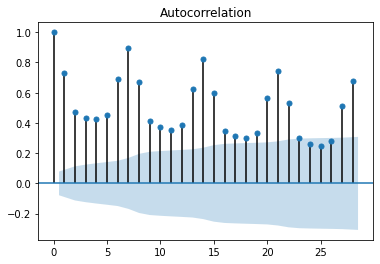

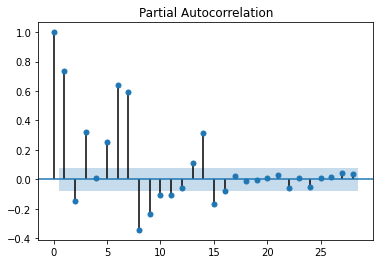

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(train);
plot_pacf(train);

### TEST FOR STATIONARITY [AUGMENT DICKEY-FULLER TEST] 

In [21]:
from statsmodels.tsa.stattools import adfuller
adfuller(train)

(-2.1214841789836143,
 0.23596391157951196,
 14,
 609,
 {'1%': -3.4411333783123306,
  '10%': -2.5693036822323063,
  '5%': -2.866297570345007},
 10643.952490016174)

The p(0.23596) > 0.05 so the Total patronage data is following non stationary

we can calculate arima parameters [p,d,q] by above plots and test.But we have another method auto arima to calculate a best parameters for us

### AUTO ARIMA

In [22]:
from pmdarima import auto_arima
ar=auto_arima(train,startp=0,startq=0,max_p=5,max_q=5,seasonal=True,trace=True,m=7)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=11117.867, Time=2.99 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=11981.245, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=11233.241, Time=1.29 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=11595.533, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=11979.246, Time=0.02 sec
 ARIMA(2,1,2)(0,0,1)[7] intercept   : AIC=11438.519, Time=2.25 sec
 ARIMA(2,1,2)(1,0,0)[7] intercept   : AIC=inf, Time=2.70 sec
 ARIMA(2,1,2)(2,0,1)[7] intercept   : AIC=11169.050, Time=4.97 sec
 ARIMA(2,1,2)(1,0,2)[7] intercept   : AIC=11117.362, Time=5.09 sec
 ARIMA(2,1,2)(0,0,2)[7] intercept   : AIC=11328.597, Time=4.33 sec
 ARIMA(2,1,2)(2,0,2)[7] intercept   : AIC=11174.088, Time=5.60 sec
 ARIMA(1,1,2)(1,0,2)[7] intercept   : AIC=11136.063, Time=4.79 sec
 ARIMA(2,1,1)(1,0,2)[7] intercept   : AIC=11070.883, Time=4.41 sec
 ARIMA(2,1,1)(0,0,2)[7] intercept   : AIC=11321.576, Time=3.33 sec
 ARIMA(2,1,1)(1,0,1)[7] i

In [23]:
ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  624
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 7)   Log Likelihood               -3117.442
Date:                           Wed, 13 Jan 2021   AIC                           6242.884
Time:                                   02:52:05   BIC                           6260.622
Sample:                                        0   HQIC                          6249.778
                                           - 624                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8605   2.09e-05  -4.11e+04      0.000      -0.861      -0.860
ar.S.L7       -1.0000   2.54e-08  -3.94e+07      0.000      -1.000      -1.000
ma.S.L7       -0.8557   2.08e-05  -4.11e+04      0.000      -0.856      -0.856
sigma2      8.129e+06      0.081      1e+08      0.000    8.13e+06    8.13e+06
===================================================================================
Ljung-Box (L1) (Q):                  11.71   Jarque-Bera (JB):             43837.37
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             2.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

By above summary we can conclude that the best values  parameters [p,d,q]=[0,1,1] 

###ARIMA MODEL

In [24]:
from statsmodels.tsa.arima.model import ARIMA,ARIMAResults
model=ARIMA(train,order=(0,1,1)).fit()
start=len(train)
end=len(train)+len(test)-1
Arima_predictions=model.predict(start,end)

###SARIMA MODEL [SEASONAL AUTO REGGRESSIVE INTEGRATED MOVING AVERAGE]

Using auto arima we calculated the parameters for SARIMA also.

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model=SARIMAX(train,order=(0, 1, 1),seasonal_order=(1, 0, 1, 7)).fit()
Sarima_predictions=model.predict(start,end)

###RECURREENT NEURAL NETWORK MODEL

PREPROCESSING

In [26]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [27]:
scaler=MinMaxScaler()
scaler.fit(np.array(train).reshape(-1,1))
x_train=scaler.transform(np.array(train).reshape(-1,1))
x_test=scaler.transform(np.array(test).reshape(-1,1))

n_inputs=7
n_features=1

gen=TimeseriesGenerator(x_train,x_train,length=n_inputs,batch_size=1)

CREATING THE RNN

In [28]:
model=Sequential()

model.add(LSTM(100,activation='relu'))

model.add(Dense(1))

model.compile('adam',loss='mse')

FITTING RNN

In [29]:
model.fit_generator(gen,epochs=25)

Epoch 1/25
617/617 [==============================] - 4s 4ms/step - loss: 0.0684
Epoch 2/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0205
Epoch 3/25
617/617 [==============================] - 2s 3ms/step - loss: 0.0159
Epoch 4/25
617/617 [==============================] - 2s 3ms/step - loss: 0.0153
Epoch 5/25
617/617 [==============================] - 2s 3ms/step - loss: 0.0120
Epoch 6/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0143
Epoch 7/25
617/617 [==============================] - 2s 3ms/step - loss: 0.0114
Epoch 8/25
617/617 [==============================] - 2s 3ms/step - loss: 0.0133
Epoch 9/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0135
Epoch 10/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0128
Epoch 11/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0127
Epoch 12/25
617/617 [==============================] - 2s 4ms/step - loss: 0.0102
Epoch 13/25
617/617 [====

HERE 25 EPOCHS IS ENOUGH TO GET THE MINIMUM MEAN SQUARE ERROR SO NO NEED TO ADD MORE EPOCHS

PREDICTING THE TEST VALUES

In [30]:
test_predict=[]

train_to_pred=x_train[-7:].reshape((1,n_inputs,n_features))

for i in range(len(test)):
  new_pred=model.predict(train_to_pred)[0]

  test_predict.append(new_pred)

  train_to_pred=np.append(train_to_pred[:,1:,:],[[new_pred]],axis=1)
RNN_predictions=scaler.inverse_transform(test_predict)  

In [31]:
Recurrent_predictions=[]
for i in RNN_predictions:
  Recurrent_predictions.append(i[0])

###PLOTTING THE TEST RESULTS [ jan 6 - jan 12]


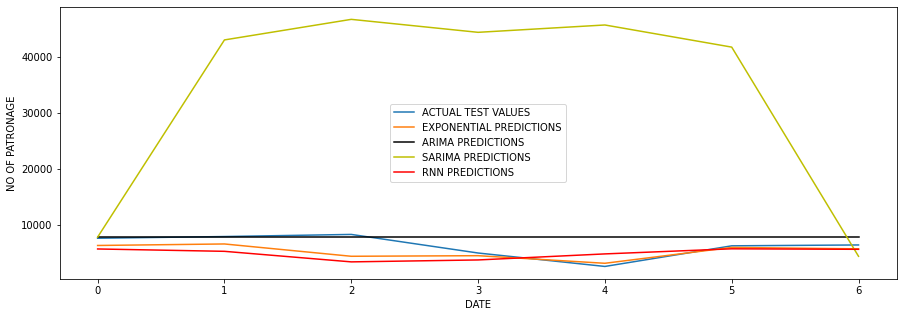

In [38]:
import matplotlib.pyplot as plt
x=[i for i in range(7)]
plt.figure(figsize=(15,5))
plt.plot(x,test,label='ACTUAL TEST VALUES')
plt.plot(x,exponential_predictions,label='EXPONENTIAL PREDICTIONS')
plt.plot(x,Arima_predictions,label='ARIMA PREDICTIONS',color='k')
plt.plot(x,Sarima_predictions,label='SARIMA PREDICTIONS',color='y')
plt.plot(x,Recurrent_predictions,label='RNN PREDICTIONS',color='r')
plt.xlabel('DATE')
plt.ylabel('NO OF PATRONAGE')
plt.legend()

Look like SARIMA is not doing well so we draw the results except sarima

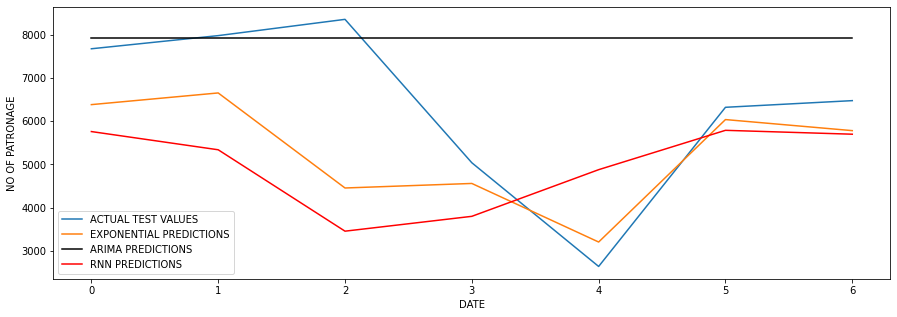

In [39]:
x=[i for i in range(7)]
plt.figure(figsize=(15,5))
plt.plot(x,test,label='ACTUAL TEST VALUES')
plt.plot(x,exponential_predictions,label='EXPONENTIAL PREDICTIONS')
plt.plot(x,Arima_predictions,label='ARIMA PREDICTIONS',color='k')
plt.plot(x,Recurrent_predictions,label='RNN PREDICTIONS',color='r')
plt.xlabel('DATE')
plt.ylabel('NO OF PATRONAGE')
plt.legend()

### MODEL SELECTION

In [40]:
from statsmodels.tools.eval_measures import mse,rmse,meanabs
print('ROOT MEAN SQUARE ERRORS\nEXPONENTIAT SMOOTHING = {}\nARIMA MODEL = {}\nSARIMA MODEL = {}\nRNN MODEL = {}'.format(rmse(test,exponential_predictions),rmse(test,Arima_predictions),rmse(test,Sarima_predictions),rmse(test,Recurrent_predictions)))

ROOT MEAN SQUARE ERRORS
EXPONENTIAT SMOOTHING = 1678.81393032443
ARIMA MODEL = 2429.601672421652
SARIMA MODEL = 32444.503607276707
RNN MODEL = 2450.283222738828


In [41]:
def confidence_interval(s):
  m=np.mean(s)
  st=np.std(s)
  #z score for 95% CI is 1.96
  upper_limit=m+(1.96*(st/np.sqrt(len(s))))
  lower_limit=m-(1.96*(st/np.sqrt(len(s))))
  return (lower_limit,upper_limit)
aa=confidence_interval(exponential_predictions)
bb=confidence_interval(Arima_predictions)
cc=confidence_interval(Sarima_predictions)
dd=confidence_interval(Recurrent_predictions)
print('COFIDENCE INTERVALS\nEXPONENTIAT SMOOTHING = {}\nARIMA MODEL = {}\nSARIMA MODEL = {}\nRNN MODEL = {}'.format(aa,bb,cc,dd))

COFIDENCE INTERVALS
EXPONENTIAT SMOOTHING = (4436.332888046792, 6155.130632924872)
ARIMA MODEL = (7931.102659752986, 7931.102659752986)
SARIMA MODEL = (20585.97301456949, 46267.88013374079)
RNN MODEL = (4295.445014797262, 5623.705328382441)


ROOT MEAN SQUARE ERROR OF EXPONENTIAL MODEL IS LOWER THAN OTHER MODELS SO WE CONCLUDE THAT EXPONENTIAL IS BEST MODEL.BECAUSE THIS IS THE MODEL WICH GIVES US BETTER PREDICTION ABOUT UNKNOWN DATA

SO NOW WE CAN PREDICT THE NEXT 7 DAYS PATRONAGE TOTAL

In [45]:
b_model=ExponentialSmoothing(data['Total'],trend='add',seasonal='mul',seasonal_periods=7).fit()
future_predictions=b_model.predict(632,638)
future_predictions

2021-01-13    6880.870058
2021-01-14    7036.815185
2021-01-15    5612.409954
2021-01-16    4434.913070
2021-01-17    2914.874053
2021-01-18    5972.095779
2021-01-19    6675.818450
Freq: D, dtype: float64

### Above the prediction of future 7 days total no of patronages

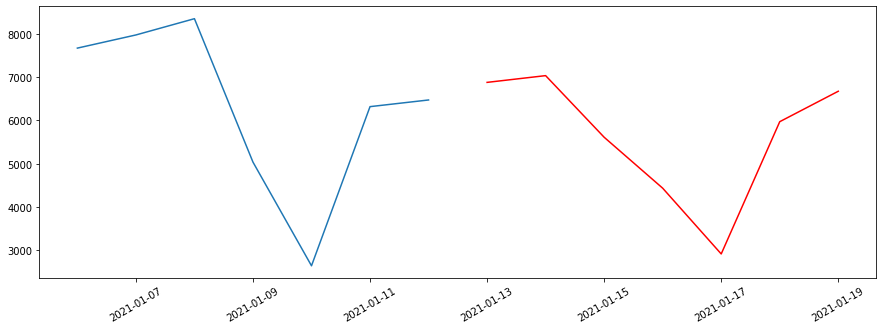

In [43]:
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as dates
plt.figure(figsize=(15,5))
dates1 =dates.date2num(list(pd.date_range(start='1/6/2021', end='1/12/2021')))
plt.plot_date(dates1, data['Total'][-7:],'-')
dates2 =dates.date2num(list(pd.date_range(start='1/13/2021', end='1/19/2021')))
plt.plot_date(dates2,future_predictions ,'r-')
plt.gca().xaxis.set_tick_params(rotation = 30)

###FINAL RESULT

In [49]:
final=pd.DataFrame(future_predictions)
a=[int(i) for i in future_predictions]
final.rename(columns={0:'TOTAL PATRONAGE'},inplace=True)
final.index.name='DATES'
final['TOTAL PATRONAGE']=a
final

,TOTAL PATRONAGE
DATES,
2021-01-13,6880
2021-01-14,7036
2021-01-15,5612
2021-01-16,4434
2021-01-17,2914
2021-01-18,5972
2021-01-19,6675


###SO WE CAN CONCLUDE THAT WE WILL EXPECT ABOVE TOTAL PATRONAGE FOR FUTURE 7 DAYS

###                         !!! THANK YOU !!!